# CS-405 Deep Learning BS-CS/SE Fall-2023

### Submitted by Hareem Bilal Malik - 344043, Hafsa Hassan -

### Installing the FaceNet PyTorch Model

In [ ]:
!pip install facenet-pytorch

## Checking CUDA Availibility

In [ ]:
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print ('<== CUDA availability : ==>', use_cuda)

torch.manual_seed(42)

<== CUDA availability : ==> True


## Importing the Required Libraries

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from facenet_pytorch import MTCNN
from tqdm import tqdm

## Preprocessing the Dataset

We preprocess our training data to crop the provided images to just the faces. We use MTCNN or Multi-Task Cascaded Convolutional Neural Networks, which is a neural network that detects faces and facial landmarks on images. The process consists of three stages of convolutional networks that are able to recognize faces and landmark location such as eyes, nose, and mouth.

In [ ]:
root_directory = r'/kaggle/input/face-classification-deep-learning-cs-405/dataset/train'

transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
])

class CustomDataset(Dataset):
    def __init__(self, root_directory):
        self.root_directory = root_directory
        self.identity_directories = sorted(os.listdir(root_directory))
        self.transform = transform
        self.mtcnn = MTCNN()
        self.identity_mapping = {identity: label for label, identity in enumerate(self.identity_directories)}
        self.data = []

        for identity_label, identity in enumerate(self.identity_directories):
            images = os.listdir(os.path.join(root_directory, identity))
            for image in images:
                image_path = os.path.join(root_directory, identity, image)
                self.data.append((image_path, identity_label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path, identity_label = self.data[index]
        img = Image.open(image_path)
        boxes, probs = self.mtcnn.detect(img)

        if boxes is not None:
            face = img.crop((boxes[0][0], boxes[0][1], boxes[0][2], boxes[0][3]))  # Cropping the face
            face_transformed = self.transform(face)
            return face_transformed, torch.tensor(identity_label)

        else:
            return None

dataset = CustomDataset(root_directory)

In [ ]:
dataset = CustomDataset(root_directory)
label_mapping = dataset.identity_mapping
print(label_mapping)

## Splitting the Dataset

In [ ]:
from torch.utils.data import DataLoader

train_size = int(0.7 * len(dataset))
validation_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - validation_size

train_data, validation_data, test_data = torch.utils.data.random_split(
    dataset, [train_size, validation_size, test_size]
)

## Creating training, validation, and testing dataloaders

In [ ]:
batch_size = 128

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=lambda x: [sample for sample in x if sample is not None], num_workers=2)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False, collate_fn=lambda x: [sample for sample in x if sample is not None])
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=lambda x: [sample for sample in x if sample is not None])
len(train_loader), len(validation_loader), len(test_loader)

(766, 165, 165)

## Displaying Images

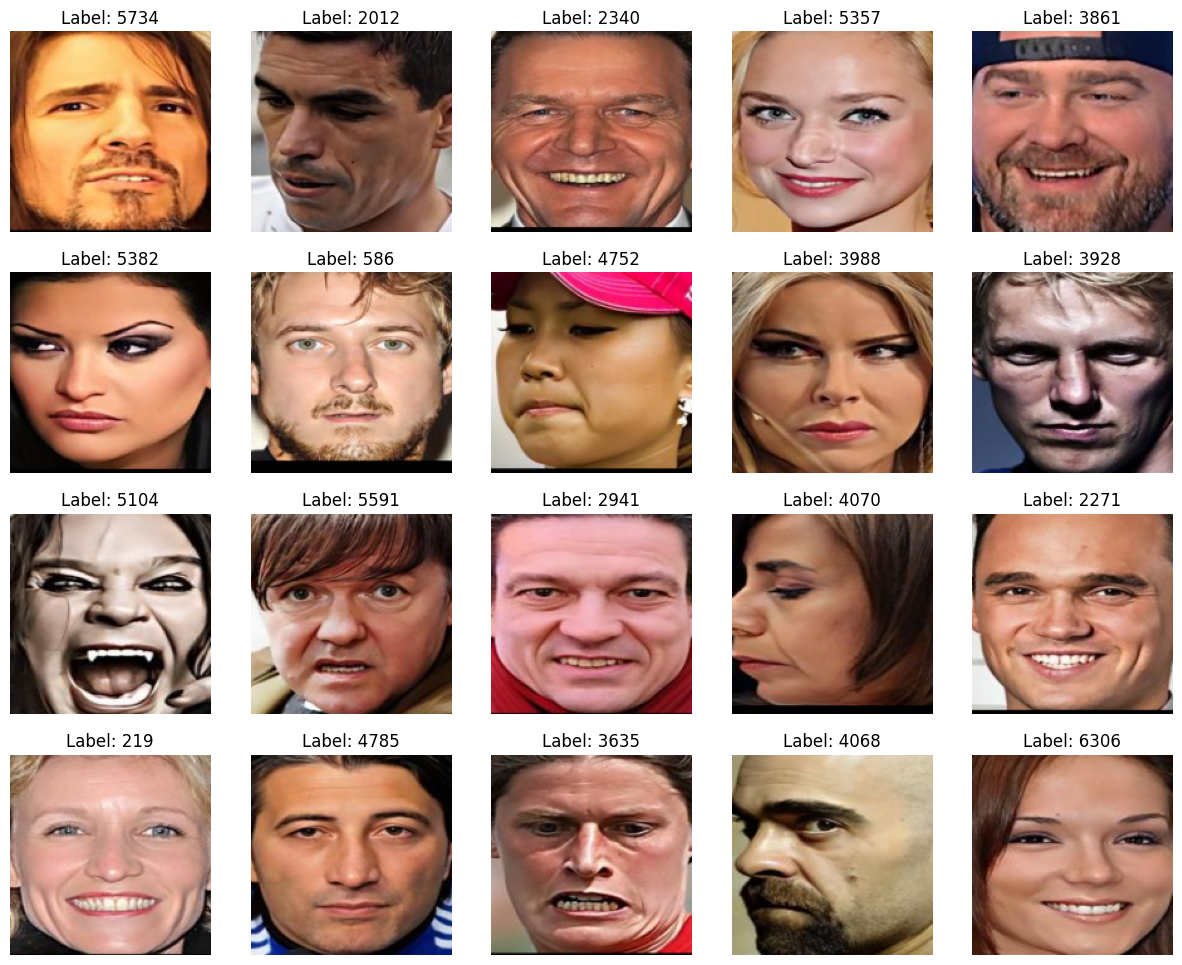

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_images(loader):
    data_iter = iter(loader)
    batch = next(data_iter)

    inputs, labels = zip(*batch)

    inputs = np.array([item.numpy() for item in inputs])

    def show_images(images, labels):
        num_images = 20
        num_cols = 5
        num_rows = (num_images + num_cols - 1) // num_cols

        plt.figure(figsize=(15, 3 * num_rows))
        for i in range(num_images):
            plt.subplot(num_rows, num_cols, i + 1)
            plt.imshow(np.transpose(images[i], (1, 2, 0)))
            if labels is not None:
                plt.title(f"Label: {labels[i]}")  # Show label as title
            plt.axis("off")

    show_images(inputs, labels)
    plt.show()

display_images(train_loader)

## Instantiating the Model: InceptionResNetV1

We freeze a majority of the initial layers of the model, and decide to unfreeze just the last 15. The model is pretrained on VGGFace2.

In [ ]:
from facenet_pytorch import InceptionResnetV1

num_classes = 7000

model = InceptionResnetV1(pretrained='vggface2', device=device, classify=True, num_classes=num_classes)

layers_to_unfreeze = 15
for param in model.parameters():
    param.requires_grad = False

for param in list(model.parameters())[-layers_to_unfreeze:]:
    param.requires_grad = True
print(model)

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

## Loss Function and Optimizer

In [ ]:
import torch.nn as nn
from torch import optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

checkpoint_path = '/kaggle/working/checkpoint.pth'
best_val_checkpoint_path = '/kaggle/working/best_val_checkpoint.pth'

torch.save(model.state_dict(), checkpoint_path)
torch.save(model.state_dict(), best_val_checkpoint_path)

## Training and Validation

 23%|██▎       | 173/766 [13:16<52:42,  5.33s/it] Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cbf17a58940>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 24%|██▍       | 186/766 [14:11<37:15,  3.86s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cbf17a58940>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-package

Epoch 1/2, Training Loss: 1.7085, Training Accuracy: 74.04%
Epoch 1/2, Validation Loss: 1.2571, Validation Accuracy: 80.59%


100%|██████████| 766/766 [54:41<00:00,  4.28s/it] 


Epoch 2/2, Training Loss: 0.8762, Training Accuracy: 85.89%
Epoch 2/2, Validation Loss: 1.4591, Validation Accuracy: 77.03%
Training complete.


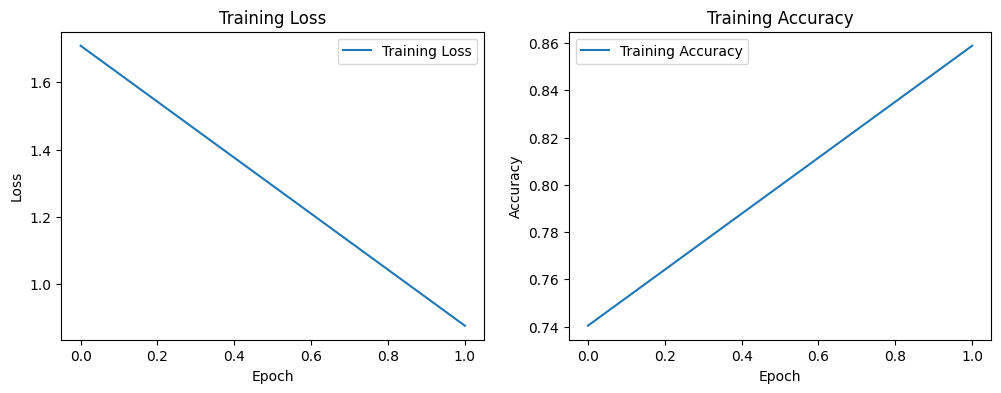

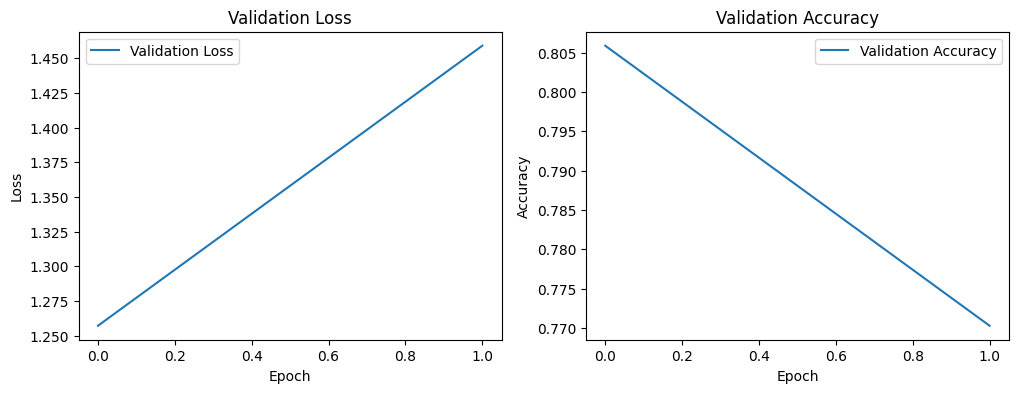

In [ ]:
from tqdm import tqdm

num_epochs = 2

def train_model(model):
    model.to(device)
    model.train()

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for batch in tqdm(train_loader):
            if batch is not None:
                inputs, labels = zip(*batch)
                inputs = torch.stack(inputs).to(device)
                labels = torch.stack(labels).to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_samples

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy * 100:.2f}%')

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
            'accuracy': epoch_accuracy
        }, checkpoint_path)

        val_loss, val_accuracy = evaluate_model(model, validation_loader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%')

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_loss,
                'accuracy': epoch_accuracy
            }, best_val_checkpoint_path)

    print('Training complete.')

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

def evaluate_model(model, dataloader):
    model.eval()
    correct_predictions = 0
    total_samples = 0

    valLoss = 0

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = zip(*batch)
            inputs = torch.stack(inputs).to(device)
            labels = torch.stack(labels).to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            valLoss += loss.item()

            _, predicted = torch.max(outputs, 1)

            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    valLoss = valLoss / len(validation_loader)
    accuracy = correct_predictions / total_samples
    return valLoss, accuracy

train_model(model)

In [ ]:
def validate_model(model):
    checkpoint = torch.load(best_val_checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)

    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm(validation_loader):
            if batch is not None:
                val_inputs, val_labels = zip(*batch)
                val_inputs = torch.stack(val_inputs).to(device)
                val_labels = torch.stack(val_labels).to(device)

                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                running_loss += val_loss.item()

                _, val_predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                correct_predictions += (val_predicted == val_labels).sum().item()

    val_loss = running_loss / len(validation_loader)
    val_accuracy = correct_predictions / total_samples

    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%')

validate_model(model)

100%|██████████| 165/165 [17:19<00:00,  6.30s/it]

Validation Loss: 1.2571, Validation Accuracy: 80.59%


## Testing the Model

In [ ]:
def test_model(model):
    checkpoint = torch.load(best_val_checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)

    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm(test_loader):
            if batch is not None:
                test_inputs, test_labels = zip(*batch)
                test_inputs = torch.stack(test_inputs).to(device)
                test_labels = torch.stack(test_labels).to(device)

                test_outputs = model(test_inputs)
                test_loss = criterion(test_outputs, test_labels)

                running_loss += test_loss.item()

                _, test_predicted = torch.max(test_outputs, 1)
                total_samples += test_labels.size(0)
                correct_predictions += (test_predicted == test_labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = correct_predictions / total_samples

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')

test_model(model)

100%|██████████| 165/165 [19:26<00:00,  7.07s/it]

Test Loss: 1.2972, Test Accuracy: 80.44%


## Performing Inference

We create another custom dataset to perform inference on our test set. This function parses through the images in the test_directory and applies the MTCNN tranform on them.

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from facenet_pytorch import MTCNN

test_directory = r'/kaggle/input/face-classification-deep-learning-cs-405/dataset/test'

class CustomTestDataset(Dataset):
    def __init__(self, test_directory):
        self.test_directory = test_directory
        self.transform = transforms.Compose([
            transforms.Resize((160, 160)),
            transforms.ToTensor(),
        ])
        self.mtcnn = MTCNN()
        self.image_paths = [f"{test_directory}/{img}" for img in os.listdir(test_directory)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        img = Image.open(img_path)
        boxes, probs = self.mtcnn.detect(img)

        if boxes is not None:
            face = img.crop((boxes[0][0], boxes[0][1], boxes[0][2], boxes[0][3]))  # Cropping the face
            face_transformed = self.transform(face)
            return face_transformed, img_path
        else:
            img = self.transform(img)
            return img, img_path

test_dataset = CustomTestDataset(test_directory)

This shows the number of batches that are being fed into the testing dataloader. Since our batch size is 128, we perform inference over 274 batches.

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)
len(test_dataloader)

274

## Generating the CSV

In [ ]:
import pandas as pd
import csv

def test_model(model, test_loader, test_directory):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    checkpoint = torch.load(best_val_checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Inference on Test Set"):
            test_inputs, _ = batch
            test_inputs = test_inputs.to(device)
            outputs = model(test_inputs)
            batch_predictions = torch.argmax(outputs, dim=1).cpu().numpy()
            predictions.extend(batch_predictions)

    image_names = os.listdir(test_directory)
    custom_dataset = CustomDataset(root_directory)
    identity_mapping = custom_dataset.identity_mapping
    inverse_mapping = {v: k for k, v in identity_mapping.items()}
    predicted_labels = [inverse_mapping[pred] for pred in predictions]

    results_df = pd.DataFrame({"image_name": image_names[:len(predictions)], "label": predicted_labels})
    results_df.to_csv("submission.csv", index=False)

    print("Predictions saved to 'submission.csv'.")

test_directory = '/kaggle/input/face-classification-deep-learning-cs-405/dataset/test'
test_model(model, test_dataloader, test_directory)

Inference on Test Set: 100%|██████████| 274/274 [34:33<00:00,  7.57s/it]


Predictions saved to 'test_predictions.csv'.
